In [13]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
from lifelines.utils import k_fold_cross_validation

In [14]:
# import data 

df = pd.read_csv('telecom_customer_churn_cox_ph_cleaned.csv')

In [15]:
df['Contract_e'] = df['Contract_e'].astype('category').cat.rename_categories({'0.0': '0', '1.0': '1'})
df['Internet_Type_Fiber Optic'] = df['Internet_Type_Fiber Optic'].astype('category').cat.rename_categories({'0.0': '0', '1.0': '1'})

In [16]:
df.head()

,Age,Tenure_in_Months,Churn_status,gender_e,married_e,paper_e,offer_e,Contract_e,Payment_Method_e,Internet_Type_Fiber Optic
0,37,9,0,0,1,1,0,1,1,0
1,46,9,0,1,0,0,0,0,1,0
2,50,4,1,1,0,1,1,0,0,1
3,78,13,1,1,1,1,1,0,0,1
4,75,3,1,0,1,1,0,0,1,1


In [17]:
df.columns

Index(['Age', 'Tenure_in_Months', 'Churn_status', 'gender_e', 'married_e',
       'paper_e', 'offer_e', 'Contract_e', 'Payment_Method_e',
       'Internet_Type_Fiber Optic'],
      dtype='object')

### Cox proportional assumption check

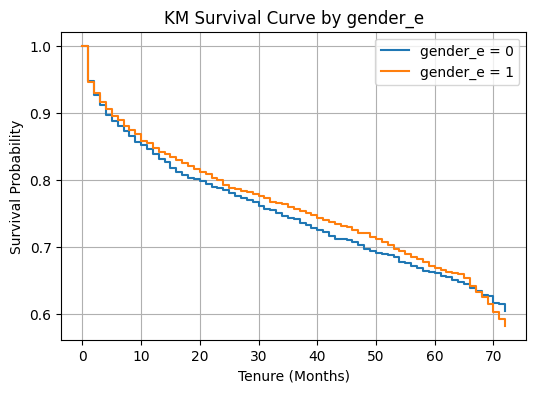

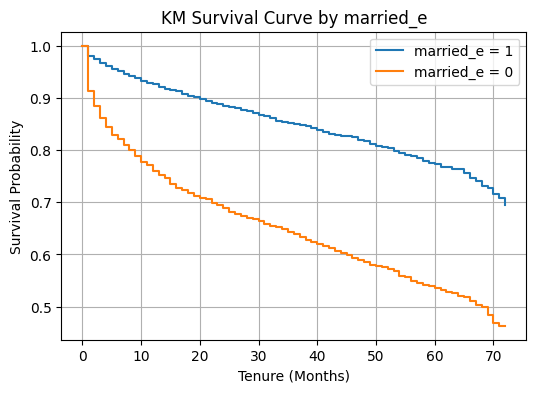

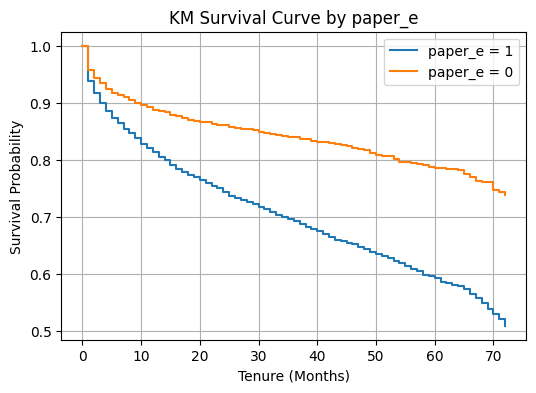

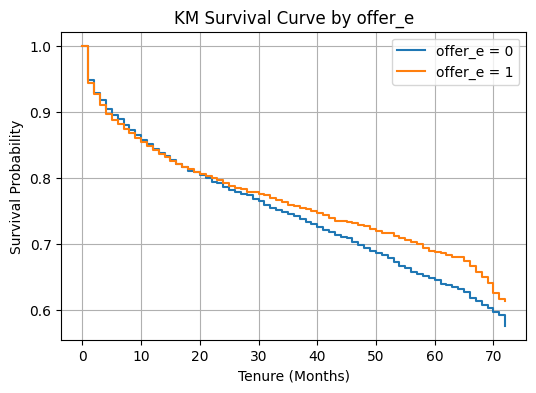

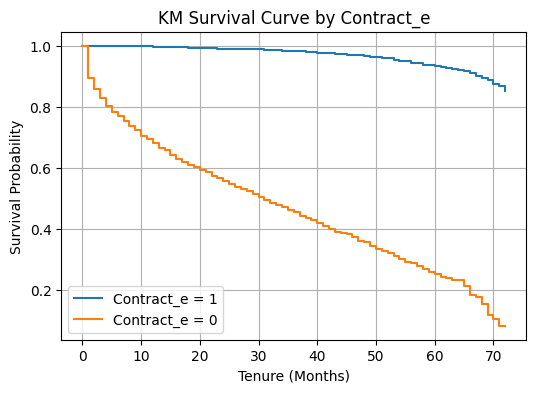

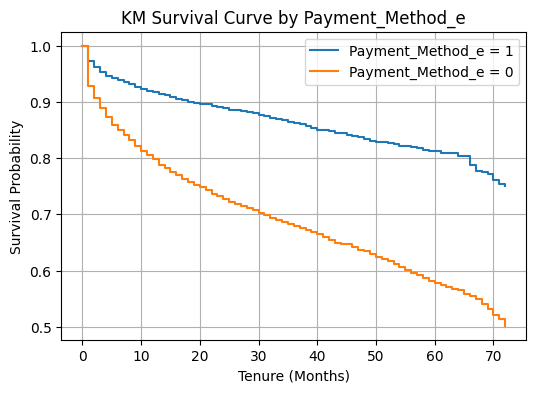

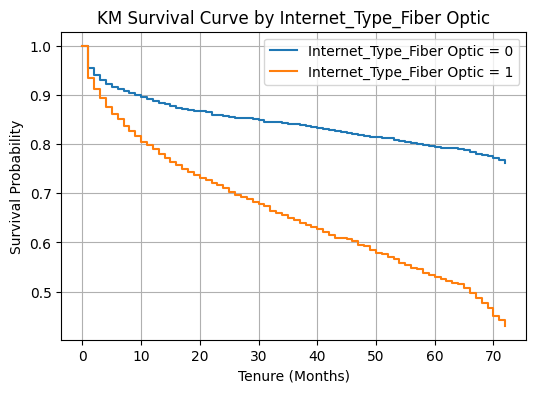

In [18]:
categorical_vars = [
    'gender_e', 
    'married_e', 
    'paper_e', 
    'offer_e', 
    'Contract_e', 
    'Payment_Method_e', 
    'Internet_Type_Fiber Optic'
]

# Set duration and event columns
T = df['Tenure_in_Months']
E = df['Churn_status']

# Loop through each categorical variable and plot
for var in categorical_vars:
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(6, 4))
    
    for group in df[var].dropna().unique():
        ix = df[var] == group
        kmf.fit(T[ix], event_observed=E[ix], label=f"{var} = {group}")
        kmf.plot(ci_show=False)
    
    plt.title(f"KM Survival Curve by {var}")
    plt.xlabel("Tenure (Months)")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()


#### Takeaway 

- Internet_Type_Fiber Optic and contract_e break assumptions too strongly ( No parallel , same shape etc)
- Add a time interaction term for offer_e to capture time trend
- Leave as is paper_e , married_e , Payment_Method_e , gender_e

### Fitting the model

In [19]:
# Adding time varying covariates

df['log_tenure'] = np.log(df['Tenure_in_Months'] + 1)

df['offer_log'] = df['offer_e'] * df['log_tenure']

# Centre the age 

#df['Age_centered'] = df['Age'] - df['Age'].median()

In [20]:
# Fitting the Cox Proportional Hazards Model with Time-Varying Covariates

from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(
    df[['Age', 'gender_e', 'married_e', 'paper_e', 'offer_e', 'offer_log',
        'Payment_Method_e', 'Tenure_in_Months', 'Churn_status','Contract_e', 'Internet_Type_Fiber Optic']],
    duration_col='Tenure_in_Months',
    event_col='Churn_status',
    strata = ['Contract_e', 'Internet_Type_Fiber Optic'])

cph.print_summary()


c:\Python Install\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'Tenure_in_Months'
                event col = 'Churn_status'
                   strata = ['Contract_e', 'Internet_Type_Fiber Optic']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -11905.54
         time fit was run = 2025-05-03 03:56:52 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age               0.01      1.01      0.00            0.01            0.01                1.01                1.01
gender_e         -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
married_e        -0.51      0.60      0.05           -0.61           -0.41                0.54                0.67
paper_e           0.23      1.26      0.06            0.12            0.34                1.13                1.40
offer_e           3.91     49.80      0.12            3.66            4.15               39.03               63.55
offer_log        -1.32      0.27      0.04           -1.40           -1.24                0.25                0.29
Payment_Method_e -0.48      0.62      0.06           -0.59           -0.36                0.55                0.69

                  cmp to      z      p  -log2(p)
covariate                                       
Age                 0.00   6.48 <0.005     33.30
gender_e            0.00  -0.83   0.41      1.29
married_e           0.00  -9.85 <0.005     73.64
paper_e             0.00   4.14 <0.005     14.82
offer_e             0.00  31.43 <0.005    717.91
offer_log           0.00 -32.23 <0.005    754.87
Payment_Method_e    0.00  -8.26 <0.005     52.61
---
Concordance = 0.75
Partial AIC = 23825.09
log-likelihood ratio test = 1438.64 on 7 df
-log2(p) of ll-ratio test = 1015.76

In [21]:
c_index_scores = k_fold_cross_validation(
    cph,
    df[['Age', 'gender_e', 'married_e', 'paper_e', 'offer_e', 'offer_log','Payment_Method_e', 'Tenure_in_Months', 'Churn_status','Contract_e', 'Internet_Type_Fiber Optic']],
    duration_col='Tenure_in_Months',
    event_col='Churn_status',
    k=5,
    scoring_method="concordance_index"
)

# Step 4: Print result
print(f"Mean C-index: {np.mean(c_index_scores):.3f}")
print(f"Fold-wise C-indices: {c_index_scores}")

c:\Python Install\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

Mean C-index: 0.817
Fold-wise C-indices: [np.float64(0.8341782671930189), np.float64(0.8023818921332336), np.float64(0.8137168507538878), np.float64(0.8192760584111245), np.float64(0.8145903027917761)]


c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Python Install\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2538: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, stratum_predicted_partial_hazards_ in predicted_partial_hazards_.groupby(self.strata):
c:\Python Install\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incre

### Insights

In [22]:
import pandas as pd
import numpy as np

data = {
    'Age': [28, 52, 28, 52],
    'gender_e': [1, 0, 1, 0],
    'married_e': [0, 1, 0, 1],
    'paper_e': [1, 1, 1, 1],
    'offer_e': [1, 1, 1, 1],
    'Tenure_in_Months': [12, 24, 12, 24],
    'Payment_Method_e': [1, 0, 1, 0],
    'Contract_e': [1, 0, 1, 0],
    'Internet_Type_Fiber Optic': [1, 0, 0, 1]
}

df = pd.DataFrame(data)
df['offer_log'] = df['offer_e'] * np.log(df['Tenure_in_Months'] + 1)


# predicting survival function for a new customer

survival_functions = cph.predict_survival_function(df)

# Display the survival functions
print(survival_functions)



             1         3         2         0
1.0   0.980357  0.976806  1.000000  1.000000
2.0   0.966961  0.961495  0.997817  1.000000
3.0   0.952252  0.946700  0.997817  1.000000
4.0   0.938178  0.930502  0.997817  0.998040
5.0   0.927582  0.914841  0.996639  0.998040
...        ...       ...       ...       ...
68.0  0.384515  0.153444  0.819361  0.635695
69.0  0.384515  0.114847  0.811883  0.613165
70.0  0.384515  0.089700  0.794918  0.564266
71.0  0.384515  0.089700  0.784404  0.537193
72.0  0.384515  0.089700  0.768647  0.487852

[72 rows x 4 columns]


In [23]:
# Create a new column for the combined label
df['contract_internet_label'] = df['Contract_e'].astype(str) + '-' + df['Internet_Type_Fiber Optic'].astype(str)

# Print the updated df to see the new labels
print(df[['Contract_e', 'Internet_Type_Fiber Optic', 'contract_internet_label']])


   Contract_e  Internet_Type_Fiber Optic contract_internet_label
0           1                          1                     1-1
1           0                          0                     0-0
2           1                          0                     1-0
3           0                          1                     0-1


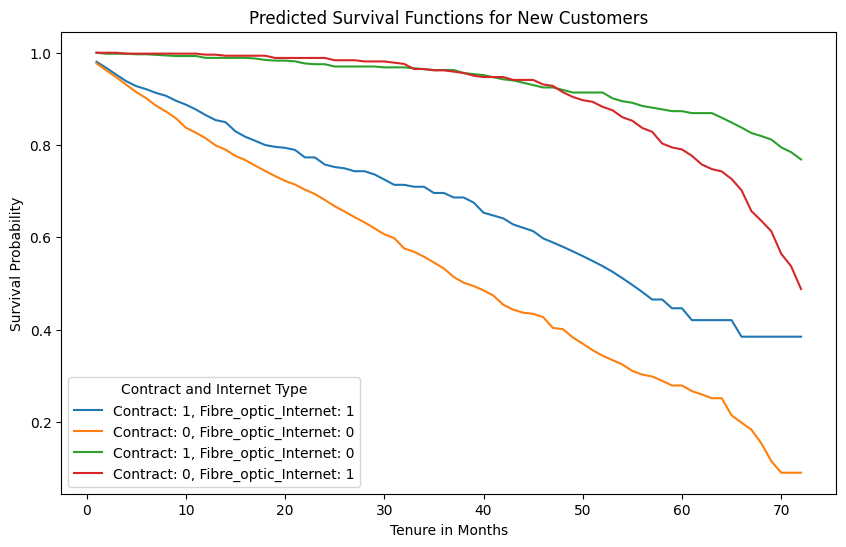

In [25]:
import matplotlib.pyplot as plt

# Plot survival functions
plt.figure(figsize=(10, 6))

# Iterate through each customer and plot their survival function
for idx, customer in enumerate(df['contract_internet_label']):
    plt.plot(survival_functions.index, survival_functions.iloc[:, idx], label=f'Contract: {df.loc[idx, "Contract_e"]}, Fibre_optic_Internet: {df.loc[idx, "Internet_Type_Fiber Optic"]}')

plt.title('Predicted Survival Functions for New Customers')
plt.xlabel('Tenure in Months')
plt.ylabel('Survival Probability')
plt.legend(title='Contract and Internet Type')
plt.grid(False)
plt.show()
